In [ ]:
!git clone https://github.com/HUMANITICS/ml-test.git
%cd ml-test

/content/drive/MyDrive/store_retail/ml-test


The Dataset we explored in the **data_exploration_analysis.ipynb** notebook is relatively small (less than 10000 time steps) and does not contain complicated patterns. For this we will first try some statistical models for time series forecasting (**SARIMA , SARIMAX and VAR**). We will Compare between them and see to which extend one of them could serve the task in hand.

In [ ]:
import random
from typing import Union
from tqdm import tqdm_notebook
from tqdm import tqdm
from itertools import product
import warnings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install dcor

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import scipy
import dcor

In [ ]:
from tensorflow.keras.losses import MeanSquaredError , MeanAbsoluteError

In [ ]:
df = pd.read_csv("stores_sales.csv")
print(f"The shape of this data is {df.shape}")
df.head(2)

The shape of this data is (6435, 8)


,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106


In [ ]:
df.index = pd.to_datetime(df['date'] , format = "%d-%m-%Y")
df.drop(["date"] , axis=1 , inplace=True)
df.head(3)

,store,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment
date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106


We have previously found in **data_exploration_analysis.ipynb** that the dataset does not contain any missing time step.

**1.  The internal structure of the data**

The following function plots the internal structure (Trend compenent, seasonality compenent and the risiduals) of the weekly sales of a given store.

In [ ]:
def plot_internal_structure(df = df , feature = "weekly_sales" , store_index = 12):

    decomposition = STL(df[df["store"]==store_index][feature], period=4).fit()  # Period=4 because there is a monthly seasonality (1month=4weeks)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

    ax1.plot(decomposition.observed)
    ax1.set_ylabel('Observed')

    ax2.plot(decomposition.trend)
    ax2.set_ylabel('Trend')

    ax3.plot(decomposition.seasonal)
    ax3.set_ylabel('Seasonal')

    ax4.plot(decomposition.resid)
    ax4.set_ylabel('Residuals')

    fig.autofmt_xdate()
    plt.tight_layout()

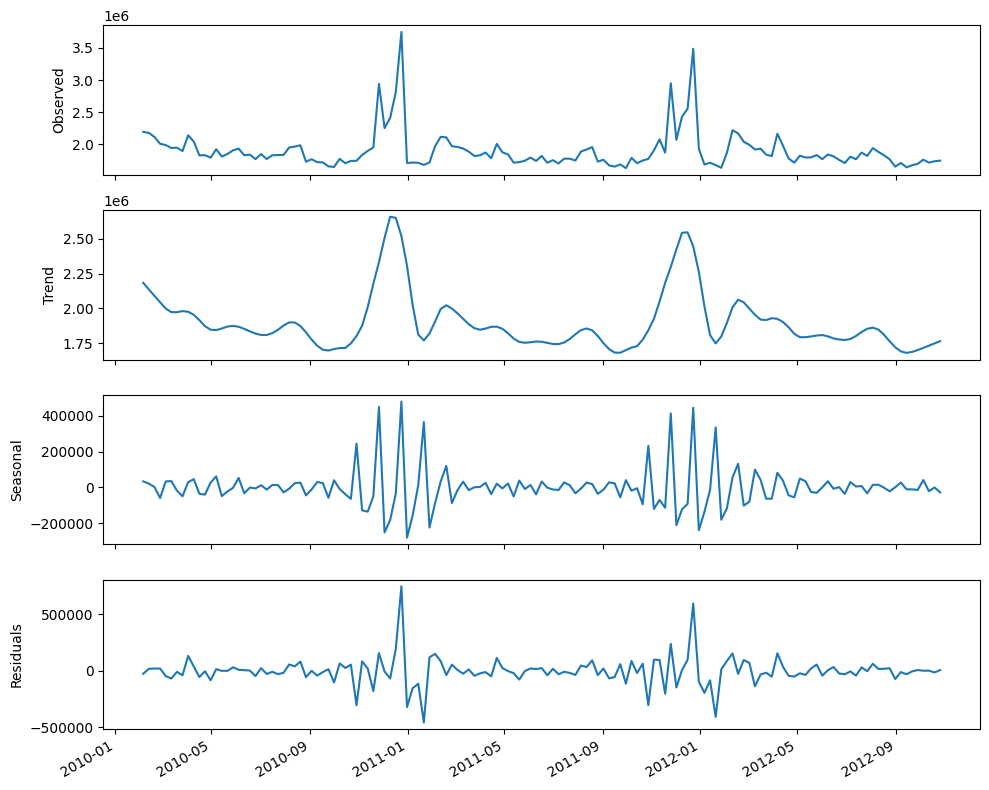

In [ ]:
store_index = 10
plot_internal_structure(store_index = store_index)

We easily remark the data for the majority of stores has a monthly seasonality but there's no a clear trend.

We will verify the stationarity of the weekly_sales time series of each store. For this, we will use the **ADF test** to verify stationarity. The **NULL hypotesis**  that there is a unit root present in atime series and therefore the TS is not stationary.  The **Alternative hypothesis** is that there is no unit root, and therefore the time series is stationary. If its **p_value** is less than 0.05,we can reject the null hypothesis and adopt the alternative hypothesis (It is stationary).

In [ ]:
stationary_TS = {}
stationarity_state = {}
non_stationary_TS = {}
for store_index in df["store"].unique():
    ad_fuller_result = adfuller(df[df["store"]==store_index]["weekly_sales"])
    p_value = ad_fuller_result[1]
    if p_value < 0.05:
        stationarity_state[store_index] = "stationary_TS"
        stationary_TS[store_index] = p_value
    else:
         stationarity_state[store_index] = "non_stationary_TS"
         non_stationary_TS[store_index] = p_value

In [ ]:
print(f"The stores whose weekly_sales TS are not stationary : {non_stationary_TS.keys()}")

The stores whose weekly_sales TS are not stationary : dict_keys([14, 30, 36, 38, 42, 43, 44])


In [ ]:
non_stationary_TS

{14: 0.06786986708375098,
 30: 0.16836387986791534,
 36: 0.9730158839006193,
 38: 0.9165634765957081,
 42: 0.45728516225718036,
 43: 0.10605876999786595,
 44: 0.7591618635707303}

We remark that in contrast to most of stores; these ones have a clear trend. The more the p_value is high the more the trend is clear.

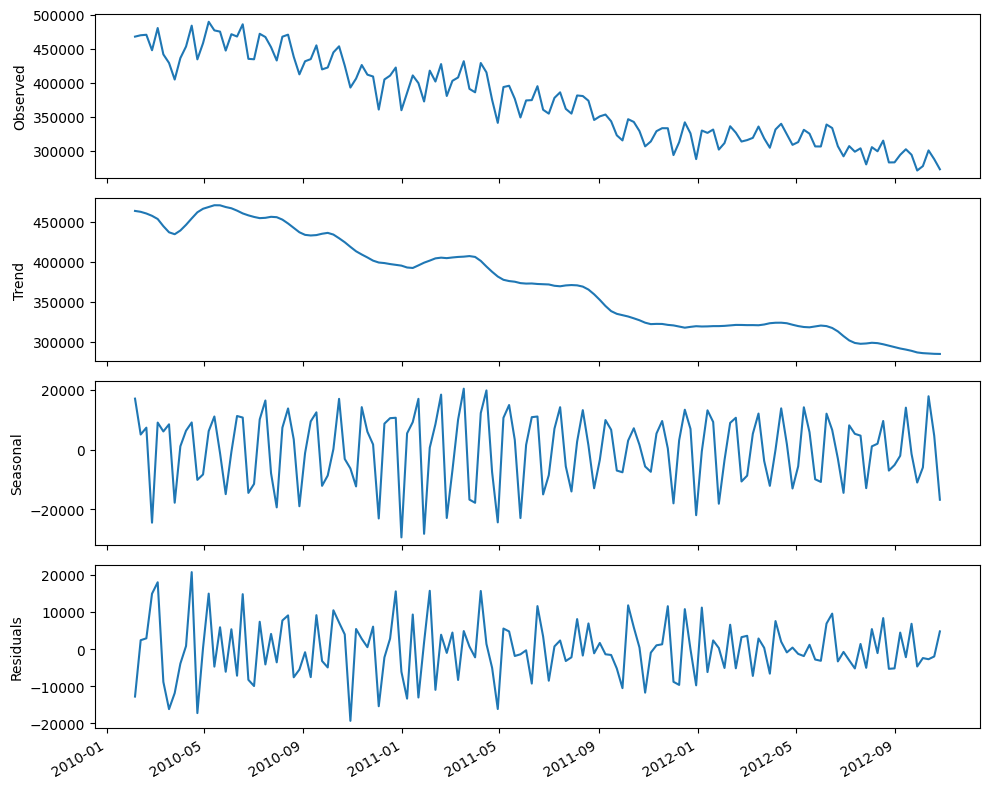

In [ ]:
store_index = 36
plot_internal_structure(store_index = store_index)

There are stores whose weekly_sales patterns are similar while they are others who have their own pattern. For each store will build its own model.

**Feature Engineering and Correlations.**

In [ ]:
df_copy = df.copy()

df_copy['temperature(t-1)'] = df_copy['temperature'].shift(1)
df_copy['fuel_Price(t-1)'] = df_copy['fuel_Price'].shift(1)
df_copy['cpi(t-1)'] = df['cpi'].shift(1)
df_copy['unemployment(t-1)'] = df_copy['unemployment'].shift(1)
df_copy['holiday_flag(t-1)'] = df_copy['holiday_flag'].shift(1)
df_copy['weekly_sales(t-1)'] = df_copy['weekly_sales'].shift(1)
df_copy['weekly_sales(t-2)'] = df_copy['weekly_sales(t-1)'].shift(1)
df_copy['weekly_sales(t-3)'] = df_copy['weekly_sales(t-2)'].shift(1)
df_copy['weekly_sales(t-4)'] = df_copy['weekly_sales(t-3)'].shift(1)
df_copy['weekly_sales(t-5)'] = df_copy['weekly_sales(t-4)'].shift(1)
df_copy['weekly_sales(t-6)'] = df_copy['weekly_sales(t-5)'].shift(1)
df_copy['weekly_sales(t-7)'] = df_copy['weekly_sales(t-6)'].shift(1)
df_copy.drop(["store"] , axis=1 , inplace=True)



df_copy.head()

,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment,temperature(t-1),fuel_Price(t-1),cpi(t-1),unemployment(t-1),holiday_flag(t-1),weekly_sales(t-1),weekly_sales(t-2),weekly_sales(t-3),weekly_sales(t-4),weekly_sales(t-5),weekly_sales(t-6),weekly_sales(t-7)
date,,,,,,,,,,,,,,,,,,
2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,42.31,2.572,211.096358,8.106,0.0,1643690.90,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,38.51,2.548,211.242170,8.106,1.0,1641957.44,1643690.90,NaN,NaN,NaN,NaN,NaN
2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,39.93,2.514,211.289143,8.106,0.0,1611968.17,1641957.44,1643690.90,NaN,NaN,NaN,NaN
2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,46.63,2.561,211.319643,8.106,0.0,1409727.59,1611968.17,1641957.44,1643690.9,NaN,NaN,NaN


In [ ]:
correlation_matrix = df_copy.corr(method='pearson')
correlation_matrix["weekly_sales"]

weekly_sales         1.000000
holiday_flag         0.036891
temperature         -0.063810
fuel_Price           0.009464
cpi                 -0.072634
unemployment        -0.106176
temperature(t-1)    -0.061793
fuel_Price(t-1)      0.013923
cpi(t-1)            -0.072935
unemployment(t-1)   -0.107119
holiday_flag(t-1)   -0.006232
weekly_sales(t-1)    0.945171
weekly_sales(t-2)    0.928780
weekly_sales(t-3)    0.911990
weekly_sales(t-4)    0.913500
weekly_sales(t-5)    0.881463
weekly_sales(t-6)    0.878069
weekly_sales(t-7)    0.876630
Name: weekly_sales, dtype: float64

In [ ]:
correlation_matrix = df_copy.corr(method='spearman')
correlation_matrix["weekly_sales"]

weekly_sales         1.000000
holiday_flag         0.027774
temperature         -0.070962
fuel_Price           0.025471
cpi                 -0.055040
unemployment        -0.062354
temperature(t-1)    -0.071103
fuel_Price(t-1)      0.029260
cpi(t-1)            -0.054561
unemployment(t-1)   -0.063971
holiday_flag(t-1)   -0.003064
weekly_sales(t-1)    0.970181
weekly_sales(t-2)    0.957437
weekly_sales(t-3)    0.944794
weekly_sales(t-4)    0.940494
weekly_sales(t-5)    0.921631
weekly_sales(t-6)    0.914316
weekly_sales(t-7)    0.910048
Name: weekly_sales, dtype: float64

In [ ]:
distance_correlations = df_copy.corr(method=lambda x, y: dcor.distance_correlation(x, y))
distance_correlations["weekly_sales"]

weekly_sales         1.000000
holiday_flag         0.033034
temperature          0.092717
fuel_Price           0.037937
cpi                  0.134957
unemployment         0.145887
temperature(t-1)     0.093542
fuel_Price(t-1)      0.038345
cpi(t-1)             0.134447
unemployment(t-1)    0.146056
holiday_flag(t-1)    0.009339
weekly_sales(t-1)    0.960574
weekly_sales(t-2)    0.946297
weekly_sales(t-3)    0.932387
weekly_sales(t-4)    0.929315
weekly_sales(t-5)    0.907006
weekly_sales(t-6)    0.899671
weekly_sales(t-7)    0.896045
Name: weekly_sales, dtype: float64

Across the three correlation assessments—**Pearson, Spearman, and distance correlation**—a notable observation emerges. Both the original features and those generated through data shifts exhibit weaker correlations with the **weekly_sales** variable. This observation holds true for the specific context of store 1 in isolation as well. It becomes apparent that neither the current values nor their lagged counterparts of these variables significantly influence the 'weekly_sales' values. However, a starkly contrasting pattern emerges when examining the pronounced impact of past **weekly_sales** values on future ones. Consequently, the nature of this scenario aligns with a univariate time series problem.

In [ ]:
del df_copy

**Modeling**

**2.  Modeling**

In the second section of this notebook we will apply the TS algorithms to  **(MA, AR, ARMA, SARIMA)** for a given store weekly_sales data. In my case I experienced these algorithms for store1. You can apply them to any store you want by setting the value of store index you want to **store_id**

For each store 80% of the data will be reserved for training and the last 20% of the data for testing.

In [ ]:
store_id = 1

In [ ]:
train = df[df["store"]==store_id]["weekly_sales"][:-28]
test = df[df["store"]==store_id]["weekly_sales"][-28:]
train.shape , test.shape

((115,), (28,))

The plot_acf plots the autocorrelation of a time series. This can help to determine the moving average process term **q**.

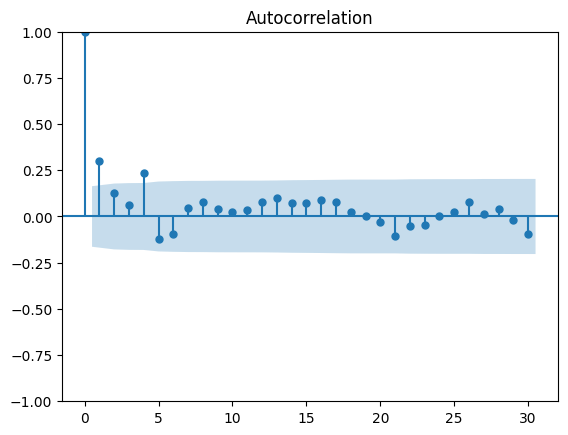

In [ ]:
store_id = 1

plot_acf(df[df["store"]==store_id]["weekly_sales"], lags=30);

The **plot_pacf** plots **the partial autocorrelation function** of a given time series. The Partial  autocorrelation  measures  the  correlation  between  lagged  values  in  a  time series when we remove the influence of correlated lagged values in between. We canplot the partial autocorrelation function to determine the order of a stationary AR(p)process. The coefficients will be non-significant after lag p.

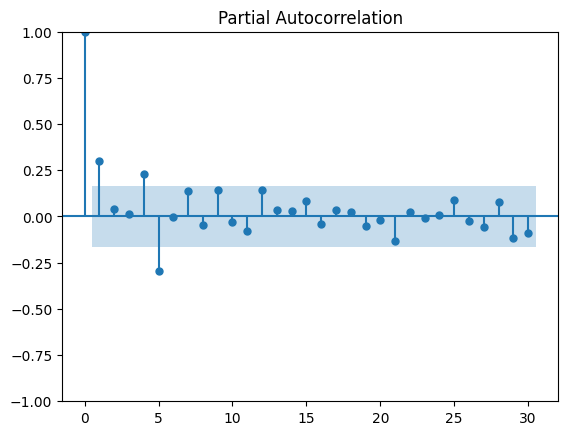

In [ ]:
plot_pacf(df[df["store"]==store_id]["weekly_sales"], lags=30);

**2.1.  Benchmark Models**

For time series problems, somtimes predicting with statistical or ML models is very bad. To measure how good the forecasting of a model is good we compare them (using mse or msa) against some classical models such as : **Naive forecasting** and **Naive Seasonality forecasting**.  

**Naive forecasting** models predict future values by simply using the most recent observed time step as the forecast. On the other hand, in cases of time series data exhibiting a seasonal pattern, the technique known as **Naive Seasonality forecasting** is applied. This method projects the upcoming season's values based on the last recorded season in the data.

In [ ]:
naive_forecast = np.array(df[df["store"]==store_id]["weekly_sales"][-29:-1])
naive_seasonality_forecast = np.array(df[df["store"]==store_id]["weekly_sales"][-32:-4])

In [ ]:
df_forecasts = pd.DataFrame()
df_forecasts["test_set"] , df_forecasts["naive_forecast"] , df_forecasts["naive_seasonality_forecast"] = test , naive_forecast , naive_seasonality_forecast

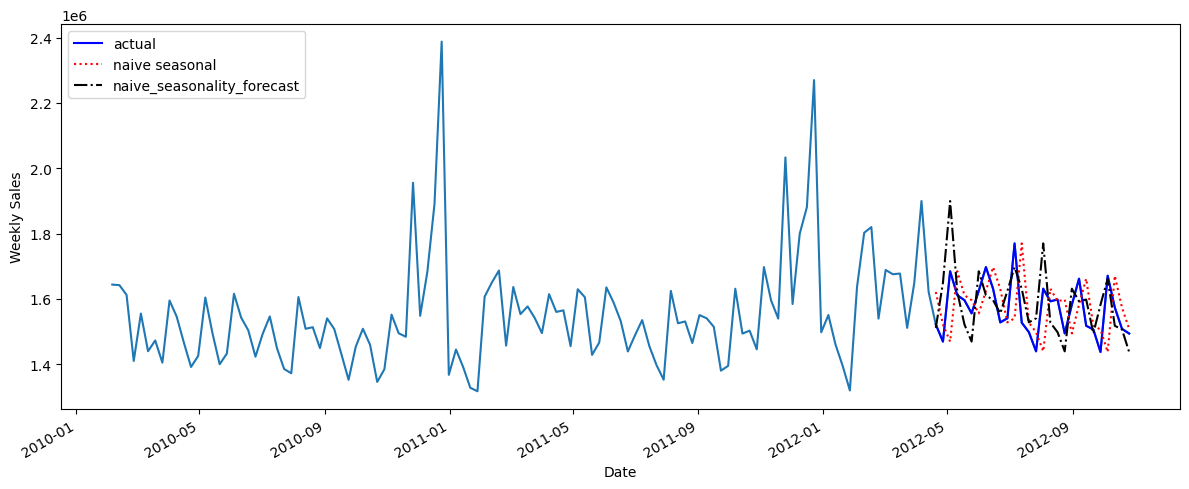

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))

ax.plot(df[df["store"]==1]["weekly_sales"])
ax.plot(df_forecasts['test_set'], 'b-', label='actual')
ax.plot(df_forecasts['naive_forecast'], 'r:', label='naive seasonal')
ax.plot(df_forecasts['naive_seasonality_forecast'], 'k-.', label='naive_seasonality_forecast')


ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')

ax.legend(loc=2)


fig.autofmt_xdate()
plt.tight_layout()

The subsections **(2.2. , 2.3. , 2.4 and 2.5.)** are reserved to experience the  **(MA, AR, ARMA, SARIMA)** process to the weekly sales of a given store. In case you want to apply them to the weekly sales of  given store that consists of a Non-Stationary structure (one of these stores [14, 30, 36, 38, 42, 43, 44]), you have first finding **the integration term d (usually equal to 1)** by calculating the number of differencing the time series needs to be stationarized. So, if you use one of these stores [14, 30, 36, 38, 42, 43, 44] apply the following code snippet:

In [ ]:
'''
Don't apply this cell except if you set store_id to one of these values:
[14, 30, 36, 38, 42, 43, 44]
'''




# df_sales_store_id = np.diff(df[df["store"]==store_id]["weekly_sales"], n=1)
# ADF_result = adfuller(df_sales_store_id)

# print(f'ADF Statistic: {ADF_result[0]}')
# print(f'p-value: {ADF_result[1]}')




'''
if the p_value is less than 0.05 so we can reject the NULL hypothesis of the ADF test.
The differenced data does not consist of a unit root. Therefore in order for this data be stationnary we have derive it one time.
So, the integration term d of the SARIMAX function will be equal to 1.

In this case, keep sure to set the integration term of the SARIMAX function to 1.
'''

'\nif the p_value is less than 0.05 so we can reject the NULL hypothesis of the ADF test. \nThe differenced data does not consist of a unit root. Therefore in order for this data be stationnary we have derive it one time. \nSo, the integration term d of the SARIMAX function will be equal to 1.\n\nIn this case, keep sure to set the integration term of the SARIMAX function to 1.\n'

**2.2.  Moving Average (MA) Algorithm**

In [ ]:
#Recursive Moving Average Forecasting:
warnings.filterwarnings("ignore")


recursive_MA_forecast = []

for i in tqdm(range(len(test))):

    # Retrain the model
    SARIMA_model = SARIMAX(df[df["store"]==store_id]["weekly_sales"].iloc[:len(train)+i], order=(0,0,4))
    SARIMA_model_fit = SARIMA_model.fit()
    step_forecast = SARIMA_model_fit.get_forecast(steps=1).predicted_mean.values[-1]
    recursive_MA_forecast.append(step_forecast)

df_forecasts["recursive_MA_forecast"] = np.array(recursive_MA_forecast)

100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


In [ ]:
print(f"Mean Absolute Error of naive_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_forecast'])}")
print(f"Mean Absolute Error of naive_seasonality_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_seasonality_forecast'])}")
print(f"Mean Absolute Error of Moving Average (MA) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_MA_forecast'])}")

Mean Absolute Error of naive_forecast is : 90136.72714285714
Mean Absolute Error of naive_seasonality_forecast is : 71970.35107142854
Mean Absolute Error of Moving Average (MA) process is : 322487.40407667804


We remark the **Moving Average process (MA)** process is even much terrible than naive_forecast.

**2.3.  AutoRegressive process (ARMA)**

In [ ]:
#Recursive AutoRegressive Forecasting:
warnings.filterwarnings("ignore")


recursive_AR_forecast = []

for i in tqdm(range(len(test))):

    # Retrain the model
    SARIMA_model = SARIMAX(df[df["store"]==store_id]["weekly_sales"].iloc[:len(train)+i], order=(4,0,0))
    SARIMA_model_fit = SARIMA_model.fit()
    step_forecast = SARIMA_model_fit.get_forecast(steps=1).predicted_mean.values[-1]
    recursive_AR_forecast.append(step_forecast)

df_forecasts["recursive_AR_forecast"] = np.array(recursive_AR_forecast)

100%|██████████| 28/28 [00:03<00:00,  9.11it/s]


In [ ]:
print(f"Mean Absolute Error of naive_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_forecast'])}")
print(f"Mean Absolute Error of naive_seasonality_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_seasonality_forecast'])}")
print(f"Mean Absolute Error of Moving Average (MA) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_MA_forecast'])}")
print(f"Mean Absolute Error of AutoRegressive (AR) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_AR_forecast'])}")

Mean Absolute Error of naive_forecast is : 90136.72714285714
Mean Absolute Error of naive_seasonality_forecast is : 71970.35107142854
Mean Absolute Error of Moving Average (MA) process is : 322487.40407667804
Mean Absolute Error of AutoRegressive (AR) process is : 62485.94979863977


We remark the **AutoRegressive** process is outperforming all the previous processes.

**2.4.  AutoRegressive Moving Average process (ARMA)**

In [ ]:
#Recursive AutoRegressive Moving Average Forecasting:
warnings.filterwarnings("ignore")


recursive_ARMA_forecast = []

for i in tqdm(range(len(test))):

    # Retrain the model
    SARIMA_model = SARIMAX(df[df["store"]==store_id]["weekly_sales"].iloc[:len(train)+i], order=(4,0,1))
    SARIMA_model_fit = SARIMA_model.fit()
    step_forecast = SARIMA_model_fit.get_forecast(steps=1).predicted_mean.values[-1]
    recursive_ARMA_forecast.append(step_forecast)

df_forecasts["recursive_ARMA_forecast"] = np.array(recursive_ARMA_forecast)

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


In [ ]:
print(f"Mean Absolute Error of naive_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_forecast'])}")
print(f"Mean Absolute Error of naive_seasonality_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_seasonality_forecast'])}")
print(f"Mean Absolute Error of Moving Average (MA) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_MA_forecast'])}")
print(f"Mean Absolute Error of AutoRegressive (AR) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_AR_forecast'])}")
print(f"Mean Absolute Error of AutoRegressive Moving Average (ARMA) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_ARMA_forecast'])}")

Mean Absolute Error of naive_forecast is : 90136.72714285714
Mean Absolute Error of naive_seasonality_forecast is : 71970.35107142854
Mean Absolute Error of Moving Average (MA) process is : 322487.40407667804
Mean Absolute Error of AutoRegressive (AR) process is : 62485.94979863977
Mean Absolute Error of AutoRegressive Moving Average (ARMA) process is : 64611.91413577216


We remark that including the MA lags to the ARMA process degrades the performance of the system. Based on my experiences, the more I increase the number of MA lags the more my model performance is degraded.

We ramark that all the previoyus processs do not incode seasonality term of the data (weekly_sales is a weekly data with monthly seasonality s=4).
The next process will be the SARIMA process wich takes into account the seasonality of the data.

**2.5.  Seasonal AutoRegressive Integrated Moving Average process (SARMA)**

In a **SARIMA** process, the seasonal component reflects the effect of seasonality on the current value, while the moving average component (MA) and autoregressive component (AR) record the impact of previous forecasting mistakes on the current value.

To choose the best parameters for the the SARIMA process, we will use the **Akaike  information  criterion  (AIC)**  which  will  determine  the optimal combination of p, q, P and Q for our time series.

In [ ]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
warnings.filterwarnings("ignore")


ps = range(0, 3 , 1)
qs = range(0, 3 , 1)
Ps = range(0, 3 , 1)
Qs = range(0, 3 , 1)

d = 0
D = 0
s = 4

SARIMA_order_list = list(product(ps, qs, Ps, Qs))


SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)

  0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
SARIMA_result_df.head(4)

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 0)",3095.076000
1,"(2, 1, 0, 1)",3096.146456
2,"(2, 1, 1, 2)",3096.894993
3,"(2, 1, 1, 1)",3096.999750


We will use the parameters assigned to the best AIC score wich are (p,q)=(2,1) and (P,Q)=(1,0)

In [ ]:
#Recursive Seasonal AutoRegressive Moving Average Forecasting:
warnings.filterwarnings("ignore")


recursive_SARIMA_forecast = []

for i in tqdm(range(len(test))):

    # Retrain the model
    SARIMA_model = SARIMAX(df[df["store"]==store_id]["weekly_sales"].iloc[:len(train)+i], order=(2,0,1), seasonal_order=(1,0,0,4))
    SARIMA_model_fit = SARIMA_model.fit()
    step_forecast = SARIMA_model_fit.get_forecast(steps=1).predicted_mean.values[-1]
    recursive_SARIMA_forecast.append(step_forecast)

df_forecasts["recursive_SARIMA_forecast"] = np.array(recursive_SARIMA_forecast)

100%|██████████| 28/28 [00:32<00:00,  1.15s/it]


In [ ]:
print(f"Mean Absolute Error of naive_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_forecast'])}")
print(f"Mean Absolute Error of naive_seasonality_forecast is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_seasonality_forecast'])}")
print(f"Mean Absolute Error of Moving Average (MA) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_MA_forecast'])}")
print(f"Mean Absolute Error of AutoRegressive (AR) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_AR_forecast'])}")
print(f"Mean Absolute Error of AutoRegressive Moving Average (ARMA) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_ARMA_forecast'])}")
print(f"Mean Absolute Error of Seasonal AutoRegressive Integrated Moving Average (SARIMA) process is : {MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_SARIMA_forecast'])}")


Mean Absolute Error of naive_forecast is : 90136.72714285714
Mean Absolute Error of naive_seasonality_forecast is : 71970.35107142854
Mean Absolute Error of Moving Average (MA) process is : 322487.40407667804
Mean Absolute Error of AutoRegressive (AR) process is : 62485.94979863977
Mean Absolute Error of AutoRegressive Moving Average (ARMA) process is : 64611.91413577216
Mean Absolute Error of Seasonal AutoRegressive Integrated Moving Average (SARIMA) process is : 58575.75607092156


The **SARIMA** process is outperforming all the other process of store1 weekly_sales data.

In the realm of time series statistical modeling, a crucial criterion for model acceptance involves the nature of the **residuals**. They are required to exhibit the property of being **Independently and Identically Distributed (iid)**. This signifies that these residuals should closely resemble a normal distribution, which effectively encapsulates the **noise** component within the data. Moreover, it's vital that these residuals remain uncorrelated—devoid of any presence of autocorrelation.


We can verify this, by the below code snippets:

In [ ]:
print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       weekly_sales   No. Observations:                  142
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 4)   Log Likelihood               -1893.258
Date:                            Sat, 26 Aug 2023   AIC                           3796.515
Time:                                    01:13:42   BIC                           3811.294
Sample:                                02-05-2010   HQIC                          3802.521
                                     - 10-19-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3726      0.068     20.085      0.000       1.239       1.507
ar.L2         -0.3726      0.068   

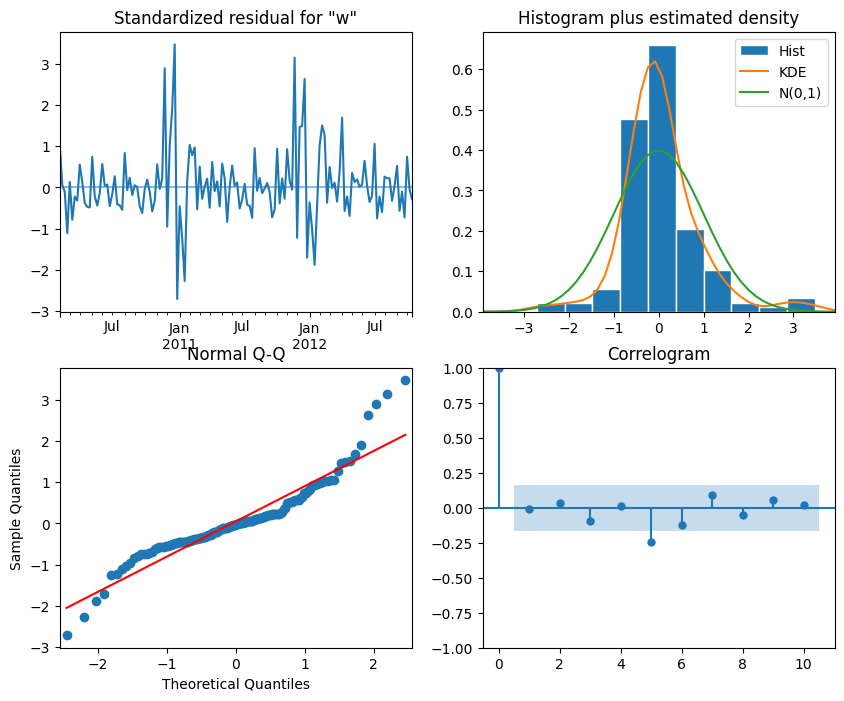

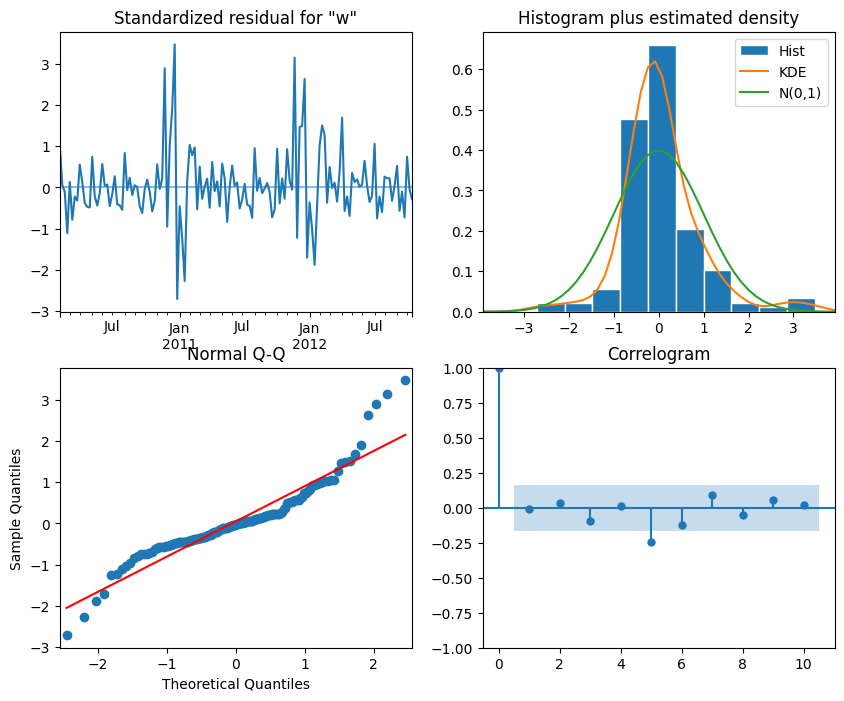

In [ ]:
warnings.filterwarnings("ignore")
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

We will use the Ljung-Box  test  to  determine  whether  the  residuals  are  correlated or not.

Within the realm of time series forecasting, the Ljung-Box test is utilized to examine the resemblance of the model's residuals to white noise. Under the null hypothesis, the data is assumed to be independently distributed, implying the absence of autocorrelation. Should the computed p-value surpass 0.05, the null hypothesis stands, signifying the independence of residuals. Consequently, the presence of autocorrelation is nullified, the residuals take on the characteristics of white noise, and the model stands validated for forecasting applications.

In [ ]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 8, 1))

,lb_stat,lb_pvalue
1,0.001213,0.972211
2,0.016780,0.991645
3,1.675038,0.642498
4,1.689479,0.792628
5,5.764776,0.329784
6,6.633281,0.356096
7,6.756019,0.454718


The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated.

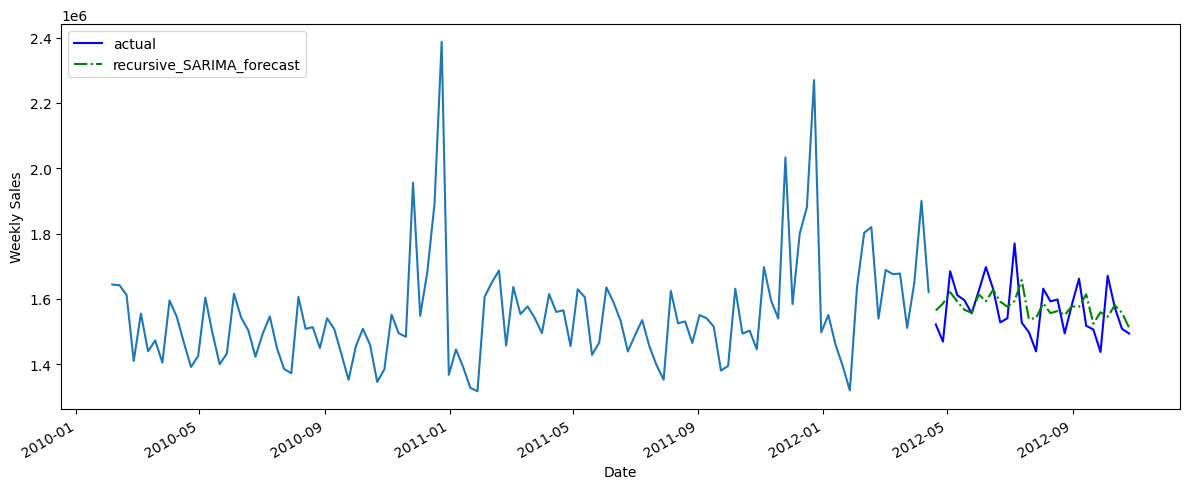

In [ ]:
fig, ax = plt.subplots(figsize = (12,5))

ax.plot(train)
ax.plot(df_forecasts['test_set'], 'b-', label='actual')
ax.plot(df_forecasts['recursive_SARIMA_forecast'], 'g-.', label='recursive_SARIMA_forecast')


ax.set_xlabel('Date')
ax.set_ylabel('Weekly Sales')

ax.legend(loc=2)


fig.autofmt_xdate()
plt.tight_layout()

**3.  Forecasting for all the stores**

Each weekly sales time series of a given store has its own internal structure and its own pattern, so the parameters (p,d) and (P,Q) will be different from a store to another. Based on experiences, I will use (p,d,q) , (P,D,Q) = (2,0,1) , (1,0,0) for stationary store weekly sales, while (p,d,q) , (P,D,Q) = (2,1,3) , (3,0,0) for the non-stationary store weekly sales.

In [ ]:
#Recursive Seasonal AutoRegressive Moving Average Forecasting:
warnings.filterwarnings("ignore")



mse_df = pd.DataFrame()
mse_naive ,  mse_naive_seasonal , mse_sarima = [] , [] , []


mae_df = pd.DataFrame()
mae_naive ,  mae_naive_seasonal , mae_sarima = [] , [] , []

for store_id in tqdm(df["store"].unique()):


    print(f"Store about processing is {store_id} ..........")

    #Data Splitting
    train = df[df["store"]==store_id]["weekly_sales"][:-28]
    test = df[df["store"]==store_id]["weekly_sales"][-28:]

    #Benchmarking Forecast
    naive_forecast = np.array(df[df["store"]==store_id]["weekly_sales"][-29:-1])
    naive_seasonality_forecast = np.array(df[df["store"]==store_id]["weekly_sales"][-32:-4])

    df_forecasts = pd.DataFrame()
    df_forecasts["test_set"] , df_forecasts["naive_forecast"] , df_forecasts["naive_seasonality_forecast"] = test , naive_forecast , naive_seasonality_forecast

    # Setting parameters
    if stationarity_state[store_index] == "stationary_TS":
        (p,d,q) , (P,D,Q) = (2,0,1) , (1,0,0)
    else:
        (p,d,q) , (P,D,Q) = (2,1,3) , (2,0,0)


    # Making SARIMA Predictions for each store
    recursive_SARIMA_forecast = []
    for i in range(len(test)):

        SARIMA_model = SARIMAX(df[df["store"]==store_id]["weekly_sales"].iloc[:len(train)+i], order=(p,d,q), seasonal_order=(P,D,Q,4))
        SARIMA_model_fit = SARIMA_model.fit()
        step_forecast = SARIMA_model_fit.get_forecast(steps=1).predicted_mean.values[-1]
        recursive_SARIMA_forecast.append(step_forecast)

    df_forecasts["recursive_SARIMA_forecast"] = np.array(recursive_SARIMA_forecast)

    #Calculating Mean Absolute Errors
    mae_naive.append(MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_forecast']))
    mae_naive_seasonal.append(MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['naive_seasonality_forecast']))
    mae_sarima.append(MeanAbsoluteError()(df_forecasts['test_set'] , df_forecasts['recursive_SARIMA_forecast']))

    #Calculating Mean Squared Errors
    mse_naive.append(MeanSquaredError()(df_forecasts['test_set'] , df_forecasts['naive_forecast']))
    mse_naive_seasonal.append(MeanSquaredError()(df_forecasts['test_set'] , df_forecasts['naive_seasonality_forecast']))
    mse_sarima.append(MeanSquaredError()(df_forecasts['test_set'] , df_forecasts['recursive_SARIMA_forecast']))


mae_df["mae_naive"] , mae_df["mae_naive_seasonal"] , mae_df["mae_sarima"] = np.array(mae_naive) , np.array(mae_naive_seasonal) , np.array(mae_sarima)
mse_df["mse_naive"] , mse_df["mse_naive_seasonal"] , mse_df["mse_sarima"] = np.array(mse_naive) , np.array(mse_naive_seasonal) , np.array(mse_sarima)

mae_df.index = range(1,46,1)
mse_df.index = range(1,46,1)

  0%|          | 0/45 [00:00<?, ?it/s]

Store about processing is 1 ..........


  2%|▏         | 1/45 [00:19<14:19, 19.52s/it]

Store about processing is 2 ..........


  4%|▍         | 2/45 [00:41<14:54, 20.80s/it]

Store about processing is 3 ..........


  7%|▋         | 3/45 [01:15<18:52, 26.95s/it]

Store about processing is 4 ..........


  9%|▉         | 4/45 [01:30<15:17, 22.38s/it]

Store about processing is 5 ..........


 11%|█         | 5/45 [02:03<17:30, 26.25s/it]

Store about processing is 6 ..........


 13%|█▎        | 6/45 [02:22<15:20, 23.60s/it]

Store about processing is 7 ..........


 16%|█▌        | 7/45 [02:59<17:39, 27.88s/it]

Store about processing is 8 ..........


 18%|█▊        | 8/45 [03:21<16:07, 26.16s/it]

Store about processing is 9 ..........


 20%|██        | 9/45 [04:07<19:19, 32.22s/it]

Store about processing is 10 ..........


 22%|██▏       | 10/45 [04:31<17:22, 29.78s/it]

Store about processing is 11 ..........


 24%|██▍       | 11/45 [04:49<14:45, 26.06s/it]

Store about processing is 12 ..........


 27%|██▋       | 12/45 [05:05<12:41, 23.08s/it]

Store about processing is 13 ..........


 29%|██▉       | 13/45 [05:32<12:55, 24.23s/it]

Store about processing is 14 ..........


 31%|███       | 14/45 [06:05<13:58, 27.04s/it]

Store about processing is 15 ..........


 33%|███▎      | 15/45 [06:36<14:05, 28.18s/it]

Store about processing is 16 ..........


 36%|███▌      | 16/45 [07:15<15:14, 31.53s/it]

Store about processing is 17 ..........


 38%|███▊      | 17/45 [07:37<13:16, 28.45s/it]

Store about processing is 18 ..........


 40%|████      | 18/45 [08:03<12:30, 27.79s/it]

Store about processing is 19 ..........


 42%|████▏     | 19/45 [08:35<12:39, 29.21s/it]

Store about processing is 20 ..........


 44%|████▍     | 20/45 [09:09<12:40, 30.44s/it]

Store about processing is 21 ..........


 47%|████▋     | 21/45 [09:42<12:34, 31.43s/it]

Store about processing is 22 ..........


 49%|████▉     | 22/45 [10:19<12:38, 33.00s/it]

Store about processing is 23 ..........


 51%|█████     | 23/45 [10:37<10:24, 28.40s/it]

Store about processing is 24 ..........


 53%|█████▎    | 24/45 [11:06<10:03, 28.72s/it]

Store about processing is 25 ..........


 56%|█████▌    | 25/45 [11:30<09:02, 27.12s/it]

Store about processing is 26 ..........


 58%|█████▊    | 26/45 [12:02<09:03, 28.62s/it]

Store about processing is 27 ..........


 60%|██████    | 27/45 [12:37<09:08, 30.47s/it]

Store about processing is 28 ..........


 62%|██████▏   | 28/45 [12:56<07:41, 27.14s/it]

Store about processing is 29 ..........


 64%|██████▍   | 29/45 [13:41<08:38, 32.39s/it]

Store about processing is 30 ..........


 67%|██████▋   | 30/45 [14:15<08:16, 33.13s/it]

Store about processing is 31 ..........


 69%|██████▉   | 31/45 [14:46<07:32, 32.35s/it]

Store about processing is 32 ..........


 71%|███████   | 32/45 [15:13<06:38, 30.65s/it]

Store about processing is 33 ..........


 73%|███████▎  | 33/45 [15:53<06:43, 33.62s/it]

Store about processing is 34 ..........


 76%|███████▌  | 34/45 [16:12<05:21, 29.25s/it]

Store about processing is 35 ..........


 78%|███████▊  | 35/45 [16:54<05:29, 32.96s/it]

Store about processing is 36 ..........


 80%|████████  | 36/45 [17:39<05:28, 36.50s/it]

Store about processing is 37 ..........


 82%|████████▏ | 37/45 [18:05<04:28, 33.56s/it]

Store about processing is 38 ..........


 84%|████████▍ | 38/45 [18:45<04:07, 35.40s/it]

Store about processing is 39 ..........


 87%|████████▋ | 39/45 [19:05<03:04, 30.74s/it]

Store about processing is 40 ..........


 89%|████████▉ | 40/45 [19:31<02:27, 29.42s/it]

Store about processing is 41 ..........


 91%|█████████ | 41/45 [20:05<02:03, 30.81s/it]

Store about processing is 42 ..........


 93%|█████████▎| 42/45 [20:43<01:38, 32.95s/it]

Store about processing is 43 ..........


 96%|█████████▌| 43/45 [21:34<01:16, 38.14s/it]

Store about processing is 44 ..........


 98%|█████████▊| 44/45 [21:59<00:34, 34.34s/it]

Store about processing is 45 ..........


100%|██████████| 45/45 [22:31<00:00, 30.04s/it]


In [ ]:
mae_df.to_csv("statistical_modeling_MAE.csv")
mse_df.to_csv("statistical_modeling_MSE.csv")

In [ ]:
mae_df

,mae_naive,mae_naive_seasonal,mae_sarima
1,90136.727143,71970.351071,63623.810516
2,81483.281071,81267.170000,64559.441360
3,17841.880000,18993.431429,17014.648746
4,71920.641786,71340.272143,50918.344467
5,15007.310714,15163.618929,11661.809412
6,74389.520357,95019.152857,64475.822159
7,27932.954643,85654.359286,35312.759249
8,32596.768214,33978.755714,25409.472184
9,23395.261071,29158.115357,20079.285605
10,61940.666429,98187.545357,50633.814131


In [ ]:
mse_df

,mse_naive,mse_naive_seasonal,mse_sarima
1,1.304006e+10,7.755212e+09,6.224669e+09
2,1.045874e+10,9.578124e+09,6.685684e+09
3,5.251918e+08,5.238562e+08,4.827320e+08
4,7.219025e+09,8.228034e+09,3.595561e+09
5,3.565480e+08,3.544499e+08,2.119441e+08
6,1.081699e+10,1.479687e+10,8.399144e+09
7,1.627458e+09,1.048369e+10,1.860806e+09
8,1.477087e+09,2.107583e+09,9.633008e+08
9,9.108579e+08,1.352459e+09,7.217675e+08
10,5.430162e+09,1.539701e+10,4.543429e+09


In [ ]:
# Mean and Median of MAE errors over the test sets of all the stores.
mae_df.mean() , mae_df.median()

(mae_naive             50734.819667
 mae_naive_seasonal    61100.378310
 mae_sarima            42750.153738
 dtype: float64,
 mae_naive             47525.538571
 mae_naive_seasonal    56400.374643
 mae_sarima            40900.278946
 dtype: float64)

In [ ]:
# Mean and Median of MSE errors over the test sets of all the stores.
mse_df.mean() , mse_df.median()

(mse_naive             5.715255e+09
 mse_naive_seasonal    8.012645e+09
 mse_sarima            3.949630e+09
 dtype: float64,
 mse_naive             3.391680e+09
 mse_naive_seasonal    5.097732e+09
 mse_sarima            2.543941e+09
 dtype: float64)

It's noteworthy that the SARIMA model has demonstrated superior performance compared to both the Naive forecast and the Seasonal Naive Forecast across a majority of stores. In instances where the SARIMA model doesn't exhibit better performance, this is attributed to the utilization of fixed (p,d,q) and (P,D,Q) hyperparameters. Remarkably, were these hyperparameters tailored and fine-tuned for each specific store using **the AIC criterion**, the SARIMA model would likely surpass them all by a substantial margin.